In [9]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scipy
from matplotlib import rc
import matplotlib
import yfinance
import seaborn as sns
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"]) 

In [3]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
asset_names = list(assets.values())
#spx = pd.read_csv('../data/spx.csv').stack().tolist()

**Downloading data and calculating returns**

In [4]:
raw_data = yfinance.download(tickers, start="2008-1-1", back_adjust=True, auto_adjust=True)
closing_prices = raw_data['Close']
closing_prices = closing_prices[tickers]
returns = closing_prices.pct_change().iloc[1:].ffill()*100 #returns
index = closing_prices/closing_prices.iloc[0]*100 #index

[*********************100%***********************]  11 of 11 completed


**Plotter index figur med alle aktiver**

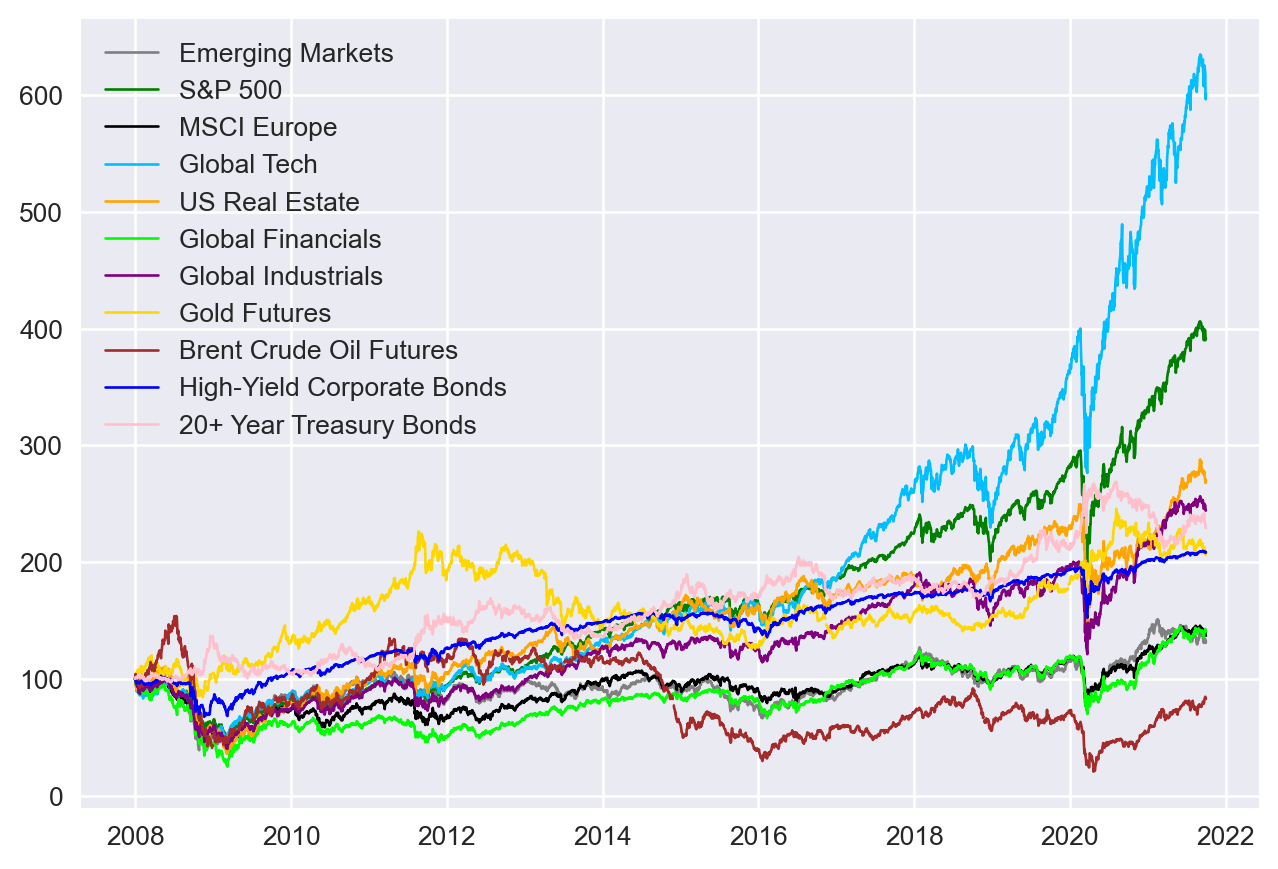

In [290]:
fig, ax = plt.subplots(1, 1, dpi=190)
ax.plot(index, label=asset_names, linewidth=1)
ax.legend()
fig.savefig("Stocks_index_plot.png", bbox_inches = 'tight', pad_inches = 0.1)

**Fitter fordelinger og laver PDF'er for udvalgte tickers, samt plotter PDF med real world data**

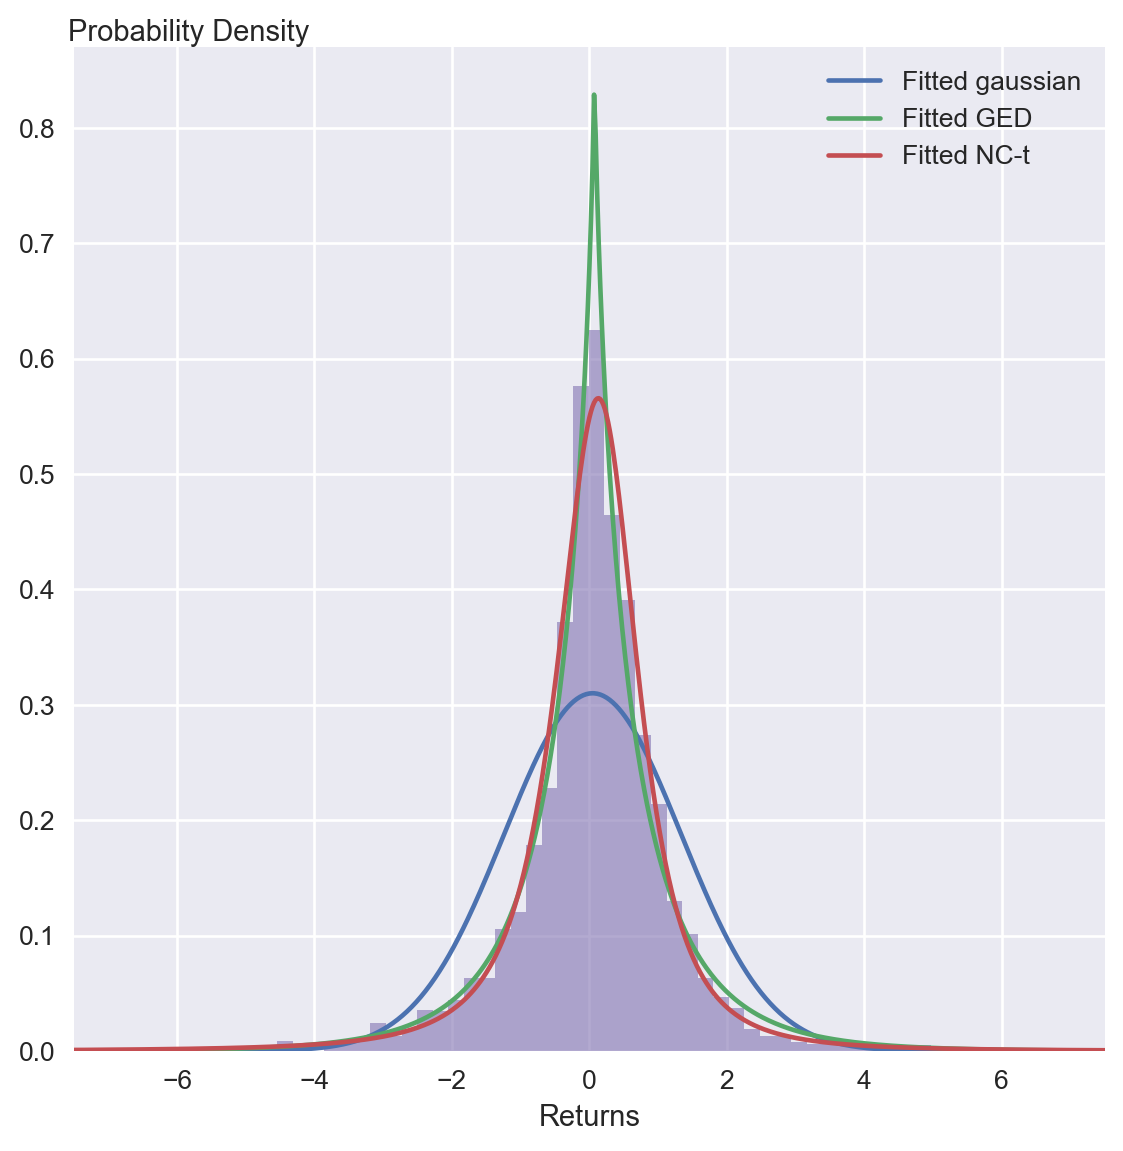

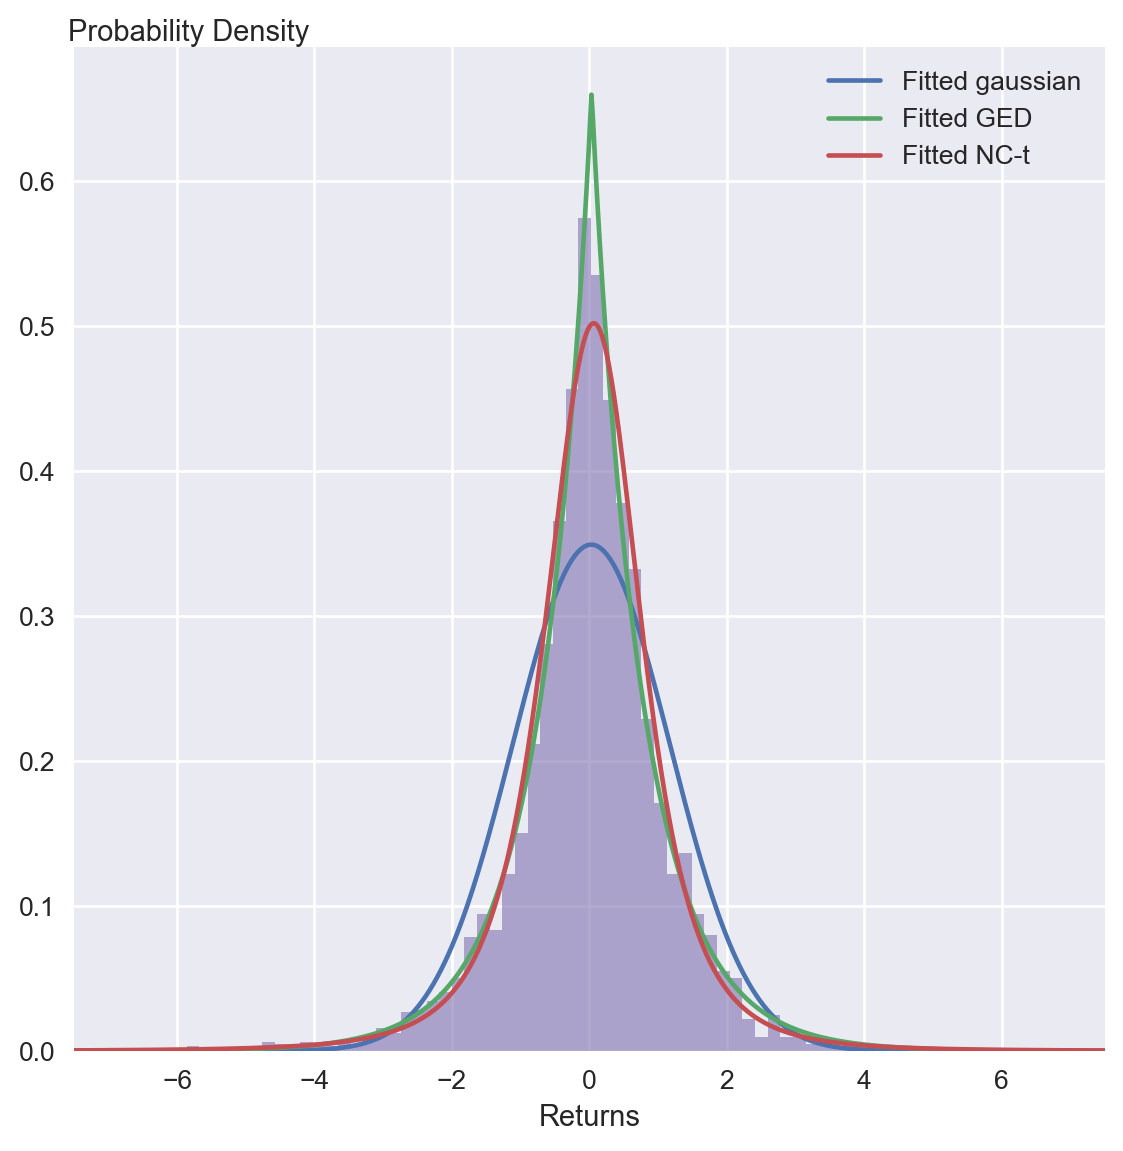

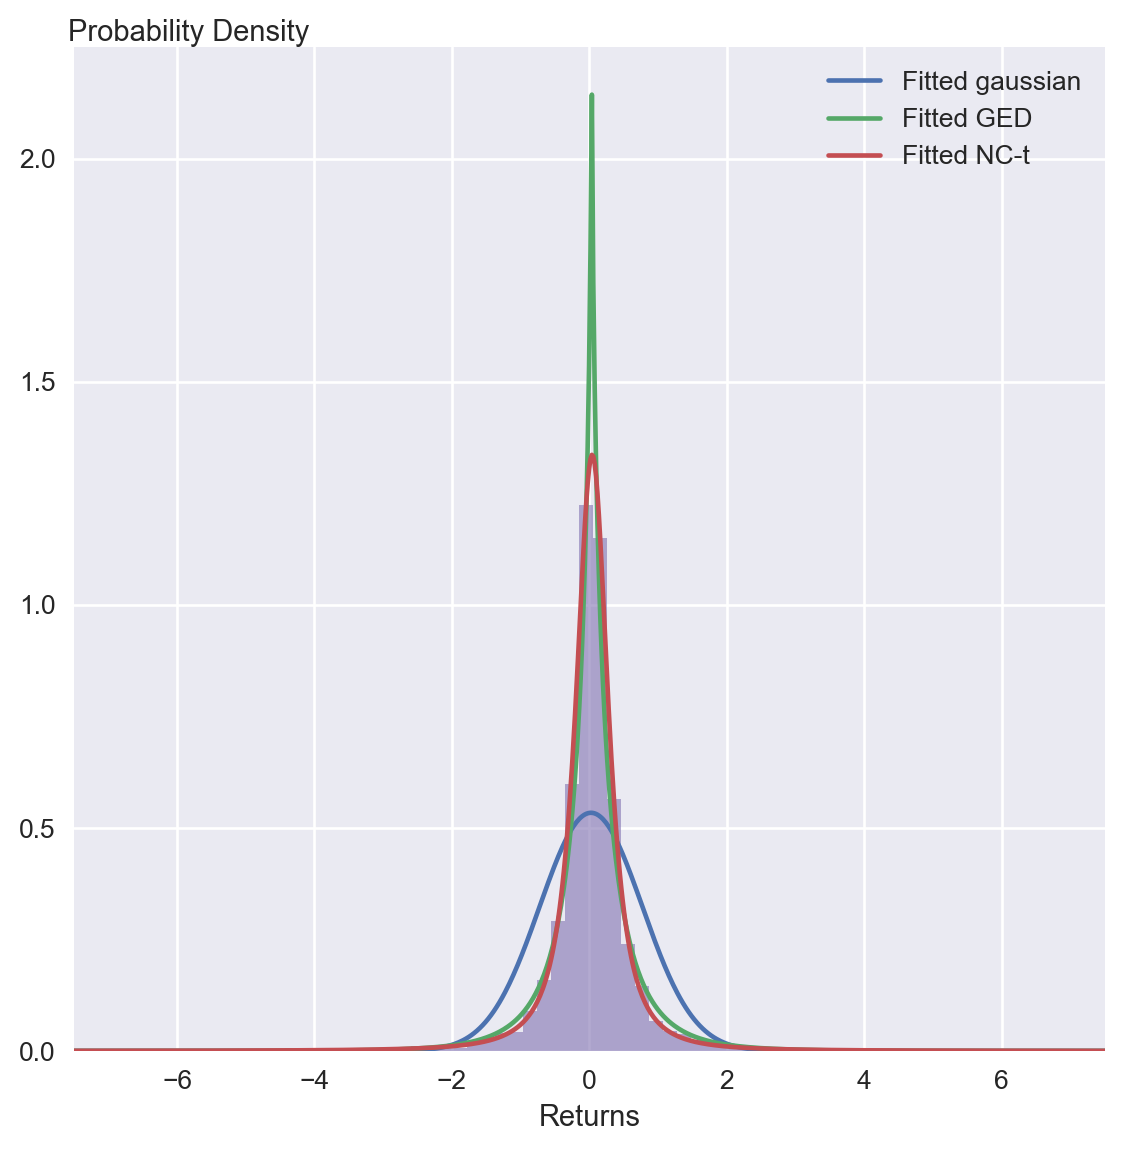

In [7]:
ticker_list=["IVV","GC=F","HYG"]

for ticker in ticker_list:
    mu, std = scipy.norm.fit(returns[ticker]) #normal distribution fi#t
    beta, loc_ged, scale_ged = scipy.gennorm.fit(returns[ticker]) #GED f#it
    df, nc_t, loc_t, scale_t = scipy.nct.fit(returns[ticker]) #non central student's t distrubiton fit

    #draw data
    xmin = returns[ticker].min()
    xmax = returns[ticker].max()
    x = np.linspace(xmin, xmax, 1000)

    normal_data=scipy.norm.pdf(x, mu, std)
    GED_data=scipy.gennorm.pdf(x, beta,loc_ged,scale_ged)
    t_data=scipy.nct.pdf(x, df,nc_t,loc_t,scale_t)
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=190)
    ax.plot(x, normal_data, label="Fitted gaussian")#, c="blue")
    ax.plot(x, GED_data, label="Fitted GED")#, c = "black")
    ax.plot(x, t_data, label ="Fitted NC-t")#, c="red")
    ax.hist(returns[ticker], bins=100, alpha=0.6, density = True)
    ax.set_xlim(-7.5, 7.5)
    ax.legend()
    ax.set_xlabel('Returns') 
    ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 
    fig.savefig(f"Density_{ticker}.png", bbox_inches = 'tight', pad_inches = 0.1)

Fitter GARCH model og plotter data

C:\Users\caspe\Anaconda3\lib\site-packages\arch\univariate\volatility.py:1145: InitialValueWarning: Parameters are not consistent with a stationary model. Using the intercept
to initialize the model.

  warn(initial_value_warning, InitialValueWarning)


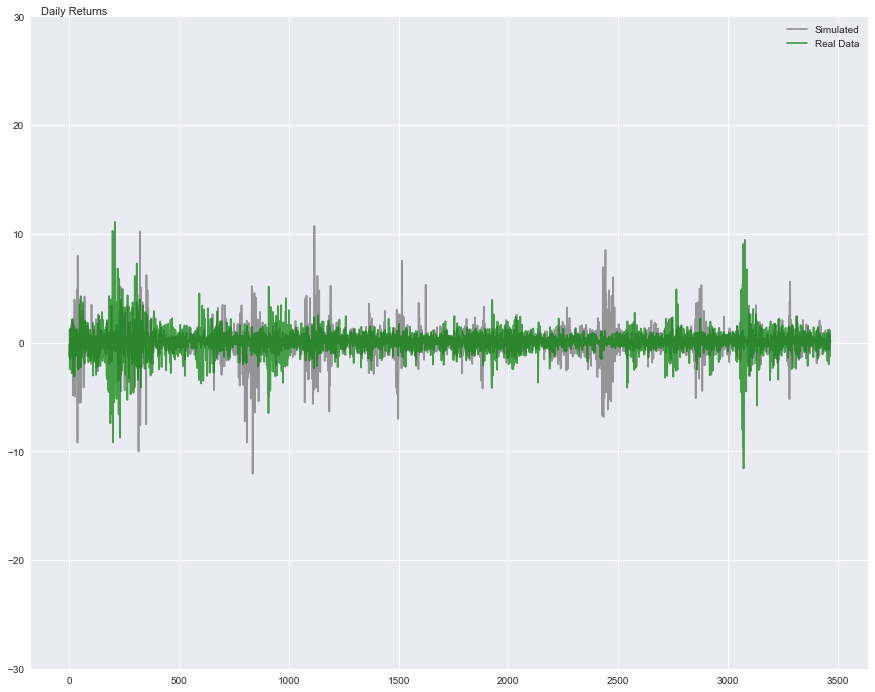

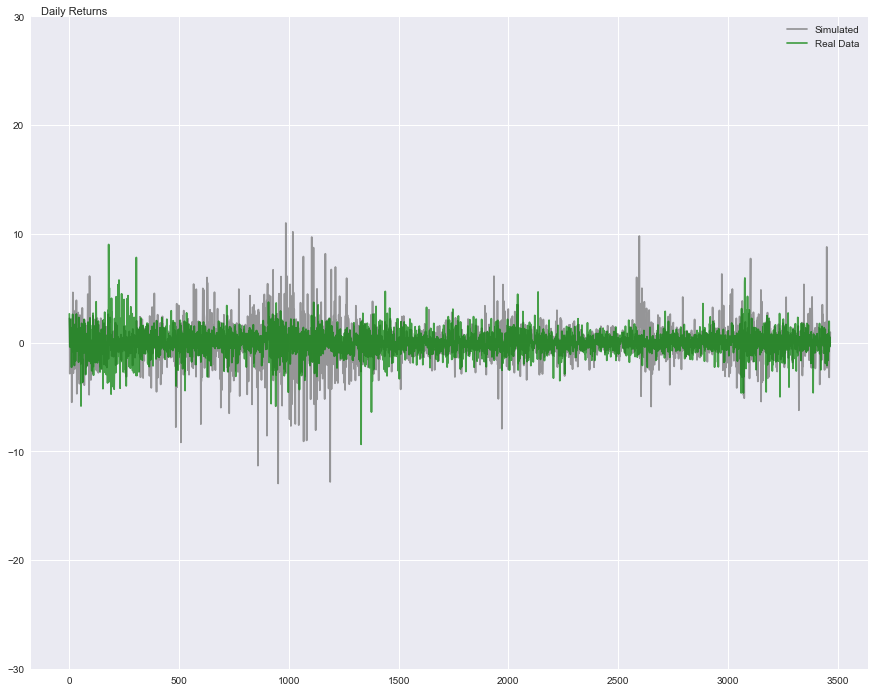

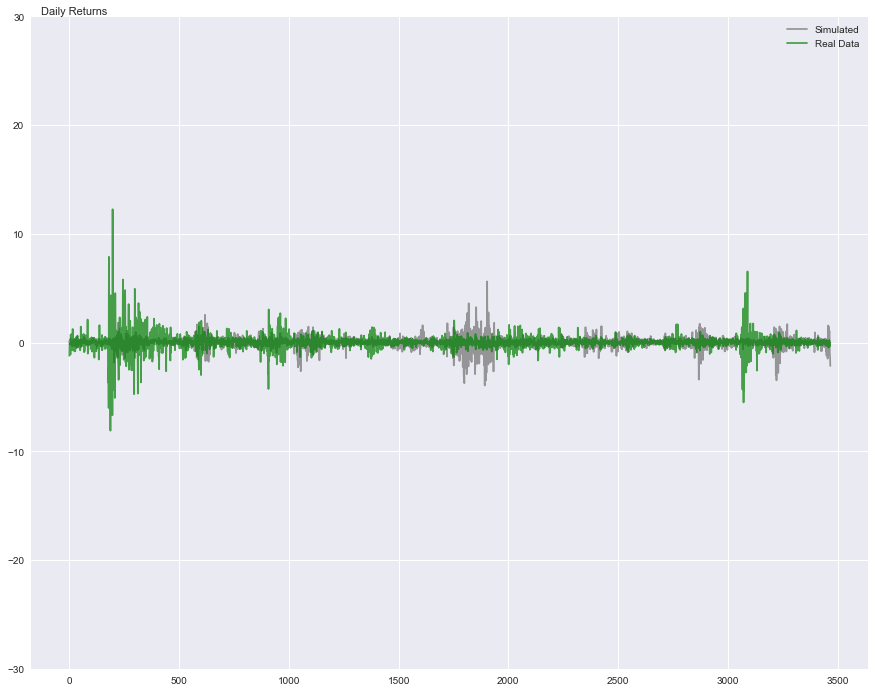

In [30]:
import arch
for ticker in ticker_list:
    #set up model:
    dist = arch.univariate.SkewStudent()
    vol = arch.univariate.GARCH(p=1, o=1, q=1)
    model = arch.univariate.ConstantMean(returns[ticker], volatility=vol, distribution=dist)
    #estimate model
    results = model.fit(disp = 'off')
    params = results.params
    #simulate data
    sim_returns = model.simulate(params, len(returns[ticker])).iloc[:,0]
    #plot simulated data
    f, ax1 = plt.subplots(1, 1, figsize=(15,12))
    ax1.plot(sim_returns, alpha=.8 , label="Simulated",c='gray')
    ax1.plot(returns[ticker].values, alpha=.7,label="Real Data",c="Green")
    ax1.set_ylabel('Daily Returns',loc='top', rotation = 0, labelpad = -100)
    ax1.legend()
    ax1.set_ylim((-30,30))
    f.savefig(f"Garch_timeseries_{ticker}.png", bbox_inches = 'tight', pad_inches = 0.1)

**Laver Jarque bera normalitets test**

In [14]:
mean = returns.mean()*250
std = returns.std()*(250**0.5)
#normality test
jarque = returns.apply(scipy.jarque_bera, axis=0)
p_values = jarque.iloc[1]
#skewed students t parameters
t_dist= returns.apply(scipy.nct.fit, axis=0) 
df_t=t_dist.iloc[0]
nc_t=t_dist.iloc[1]
loc_t=t_dist.iloc[2]
scale_t=t_dist.iloc[3]

row_names = pd.Index(['Mean', 'Std', 'P_value Jarque', 'Degrees of freedom','Non central','Location','Scale'])
stat = pd.DataFrame([mean, std, p_values, df_t, nc_t, loc_t, scale_t], columns = tickers, index = row_names)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [21]:
trans = stat.transpose().sort_values("Mean", ascending=False)

,Mean,Std,P_value Jarque,Degrees of freedom,Non central,Location,Scale
IXN,15.522886,22.820171,0.0,2.613596,-0.195074,0.292645,0.828915
IYR,12.078634,31.303084,0.0,1.817146,-0.127131,0.198092,0.776075
IVV,11.911102,20.352015,0.0,2.157688,-0.156744,0.205329,0.628554
EXI,8.962133,22.545244,0.0,2.500514,-0.178806,0.241595,0.787007
TLT,7.186187,15.014102,0.0,5.701763,-0.146889,0.154232,0.757799
GC=F,6.983438,18.073257,0.0,3.067432,-0.089160,0.117309,0.733884
IXG,6.668157,28.918514,0.0,2.107703,-0.164941,0.243321,0.869196
EEM,6.440708,29.910609,0.0,2.791937,-0.199064,0.299929,1.050346
BZ=F,6.089547,38.218866,0.0,2.481209,-0.081767,0.169453,1.325085
HYG,5.980012,11.823697,0.0,1.732086,-0.063305,0.053461,0.259994


In [26]:
(trans.Mean/trans.Std).sort_values()

BZ=F    0.159334
EEM     0.215332
IEV     0.216467
IXG     0.230584
IYR     0.385861
GC=F    0.386396
EXI     0.397518
TLT     0.478629
HYG     0.505765
IVV     0.585254
IXN     0.680227
dtype: float64

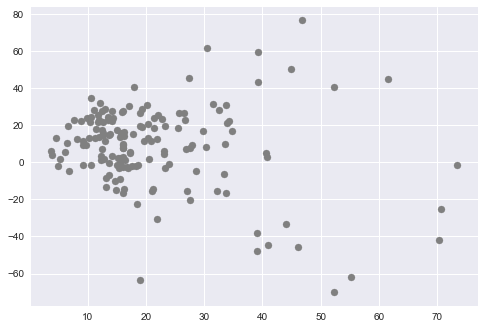

In [51]:
plt.scatter(y = avg, x = std)

**Laver cool covariance matrix**

In [45]:
cov = returns.corr()
cmap = sns.light_palette("purple", as_cmap=True, reverse = True)
s = cov.style
s.background_gradient(cmap=cmap, axis=None)
s.format({
   ("Numeric", "Integers"): '\${}',
   ("Numeric", "Floats"): '{:.3f}',
   ("Non-Numeric", "Strings"): str.upper
})
s.set_precision(2)

,EEM,IVV,IEV,IXN,IYR,IXG,EXI,GC=F,BZ=F,HYG,TLT
EEM,1.00,0.85,0.86,0.82,0.70,0.82,0.84,0.10,0.36,0.63,-0.36
IVV,0.85,1.00,0.89,0.92,0.79,0.90,0.92,0.01,0.35,0.66,-0.43
IEV,0.86,0.89,1.00,0.82,0.70,0.89,0.92,0.09,0.38,0.66,-0.42
IXN,0.82,0.92,0.82,1.00,0.68,0.80,0.84,0.03,0.32,0.61,-0.38
IYR,0.70,0.79,0.70,0.68,1.00,0.78,0.73,0.02,0.21,0.53,-0.25
IXG,0.82,0.90,0.89,0.80,0.78,1.00,0.89,-0.01,0.34,0.67,-0.45
EXI,0.84,0.92,0.92,0.84,0.73,0.89,1.00,0.06,0.37,0.67,-0.43
GC=F,0.10,0.01,0.09,0.03,0.02,-0.01,0.06,1.00,0.17,0.03,0.13
BZ=F,0.36,0.35,0.38,0.32,0.21,0.34,0.37,0.17,1.00,0.31,-0.23
HYG,0.63,0.66,0.66,0.61,0.53,0.67,0.67,0.03,0.31,1.00,-0.27


In [50]:
avg = returns.resample("Y").mean()*250
std = returns.resample("Y").std()*np.sqrt(250)

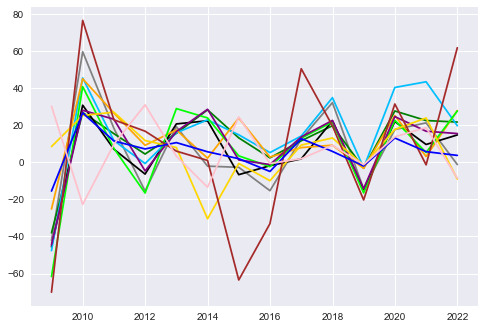

In [59]:
plt.plot(avg)